In [1]:
from fastai import *
from fastai.vision import *

from ranger import Ranger

%matplotlib inline
PATH = Path('../..').resolve()

# Unify detections/nondetection catalogs

In [2]:
# detections
a40 = pd.read_csv(f'../../results/a40_detections.csv',)

a40['id'] = a40.AGCNr.apply(lambda s: f'a40_{s}')
a40.set_index('id', inplace=True)
a40.drop('AGCNr', axis=1, inplace=True)

a40['detected'] = True
a40.sample(3)

,ra,dec,z,r,detected
id,,,,,
a40_202892,161.64958,12.22028,0.02446,16.23,True
a40_200661,163.61540,9.94972,0.03094,14.82,True
a40_226305,184.35085,7.04056,0.01247,16.02,True


In [3]:
# non-detections
nsa = pd.read_csv(f'../../results/nsa_nondetections.csv',)

nsa['id'] = nsa.NSAID.apply(lambda s: f'nsa_{s}')
nsa.set_index('id', inplace=True)
nsa.drop('NSAID', axis=1, inplace=True)

nsa['detected'] = False
nsa.sample(3)

,ra,dec,z,r,detected
id,,,,,
nsa_111815,167.368154,15.940043,0.047360,16.761118,False
nsa_77051,193.990929,8.609985,0.047028,15.773900,False
nsa_65998,165.297153,12.474752,0.026952,14.179374,False


In [4]:
nsa.shape, a40.shape

((2662, 5), (2662, 5))

**Note that the two NSAID and AGCNr *numbers* are not unique!**

In [5]:
df = pd.concat((a40, nsa)).sample(frac=1)
df.sample(5)

,ra,dec,z,r,detected
id,,,,,
a40_214284,169.64583,4.71611,0.04738,16.37,True
a40_224556,182.66585,10.55333,0.04439,16.47,True
a40_200661,163.61540,9.94972,0.03094,14.82,True
a40_200484,159.08125,13.44611,0.02225,14.33,True
a40_202193,152.36624,8.91472,0.02667,16.40,True


In [49]:
# df.to_csv('../../results/detectability_sample.csv', index=True)

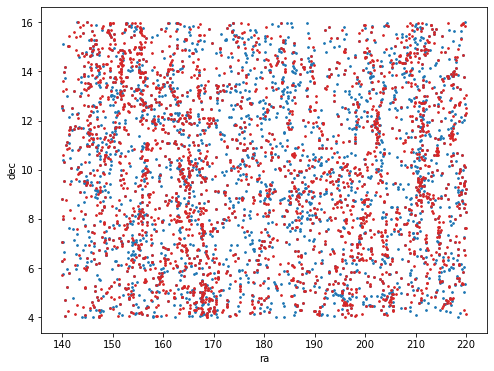

In [10]:
plt.figure(figsize=(8,6))
df[df.detected].plot.scatter('ra', 'dec', c='C0', ax=plt.gca(), s=3)
df[~df.detected].plot.scatter('ra', 'dec', c='C3', ax=plt.gca(), s=3)

# Building a model

In [21]:
df = pd.read_csv('../../results/detectability_sample.csv')

In [22]:
bs = 32
sz = 56

image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

In [23]:
il = ImageList.from_df(df, path=PATH, folder='images-detectability', suffix='.jpg', cols='id')

src = (il.split_by_rand_pct(0.2)
         .label_from_df(cols='detected')
)

data = (src.transform(tfms, size=sz)
           .databunch(bs=bs)
           .normalize(image_stats)
)

In [24]:
model = simple_cnn([3, 16, 32, 2])

In [7]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    metrics=[accuracy],
    wd=1e-4,
    bn_wd=False,
    true_wd=True,
)



In [46]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten()
  )
)

In [48]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.672251,0.662297,0.626880,00:08


# Actual training

Note: this is still at 1/4 resolution

In [9]:
learn = Learner(
    data,
    model=models.xresnet34(),
    opt_func=partial(Ranger),
    metrics=[accuracy],
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)



set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


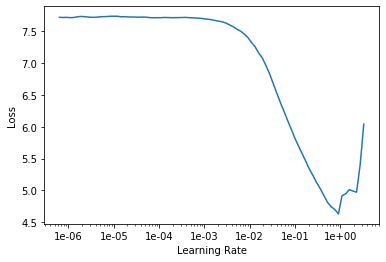

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.547721,0.627529,0.646617,00:08
1,0.712916,0.706094,0.609023,00:08
2,0.619197,0.618971,0.671053,00:08
3,0.583995,0.567309,0.701128,00:09
4,0.555357,0.540131,0.722744,00:08


## Full size images but shallow model

In [25]:
# update to full size
data = (src.transform(tfms, size=224)
           .databunch(bs=bs)
           .normalize(image_stats)
)

In [16]:
learn = Learner(
    data,
    model=models.xresnet18(),
    opt_func=partial(Ranger),
    metrics=[accuracy],
    wd=1e-4,
    bn_wd=False,
    true_wd=True,
)



In [17]:
learn.fit_fc(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.893898,0.640656,0.639098,00:11
1,0.651760,0.648058,0.597744,00:11
2,0.612534,0.629796,0.663534,00:11
3,0.611334,0.597610,0.664474,00:11
4,0.583300,0.788036,0.545113,00:11
5,0.589463,0.614341,0.656955,00:11
6,0.587269,0.615654,0.671053,00:11
7,0.577051,0.566817,0.686090,00:11
8,0.546831,0.526738,0.731203,00:11
9,0.510021,0.490742,0.758459,00:11


## Interpretation

In [18]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

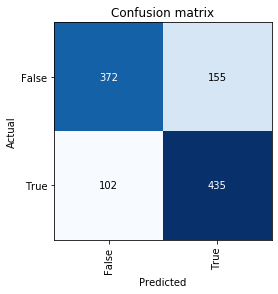

In [19]:
interp.plot_confusion_matrix()

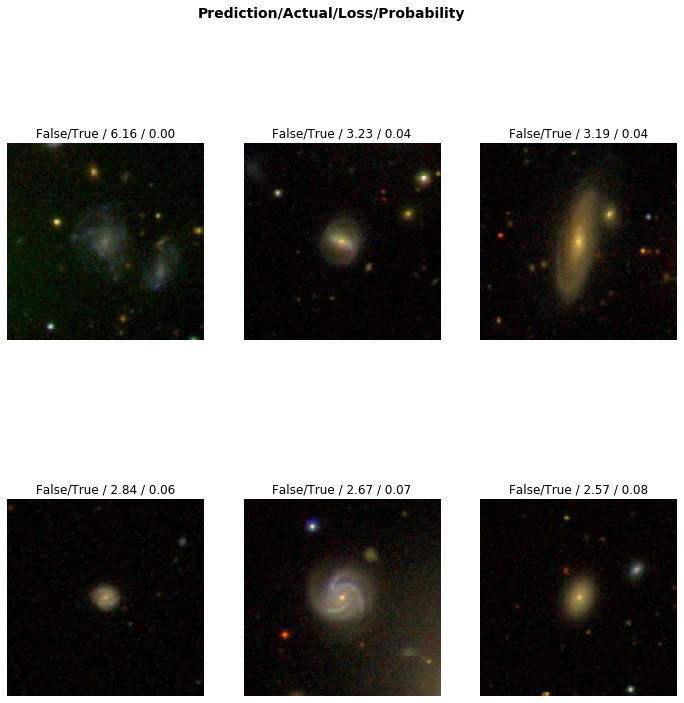

In [22]:
interp.plot_top_losses(6)

## Train with deeper model?

In [2]:
sys.path.append(f'{PATH}/src')
from mxresnet import *

Mish activation loaded...
Mish activation loaded...


In [3]:
df = pd.read_csv('../../results/detectability_sample.csv')

In [4]:
bs = 32
sz = 224

image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

In [5]:
il = ImageList.from_df(df, path=PATH, folder='images-detectability', suffix='.jpg', cols='id')

src = (il.split_by_rand_pct(0.2)
         .label_from_df(cols='detected')
)

data = (src.transform(tfms, size=sz)
           .databunch(bs=bs)
           .normalize(image_stats)
)

In [6]:
learn = Learner(
    data,
    model=mxresnet34(),
    opt_func=partial(Ranger),
    metrics=[accuracy],
    wd=1e-4,
    bn_wd=False,
    true_wd=True,
)



In [7]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.024745,3.332760,0.639098,00:21
1,0.978854,0.666773,0.614662,00:20
2,0.659027,0.622901,0.675752,00:20
3,0.621513,0.717486,0.562970,00:21
4,0.622218,0.679468,0.648496,00:20
5,0.597777,0.601207,0.679511,00:20
6,0.585523,0.574839,0.705827,00:21
7,0.576343,0.574030,0.706767,00:20
8,0.566202,0.560830,0.712406,00:20
9,0.563964,0.563777,0.707707,00:21


## Use pretrained model

In [14]:
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=[accuracy], ps=0.)

In [15]:
learn.fit_one_cycle(3, 0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.942221,0.770359,0.514098,00:11
1,0.634732,0.604536,0.663534,00:10
2,0.584320,0.581079,0.675752,00:10


In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(8, slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.595431,0.590377,0.674812,00:14
1,0.584654,0.616161,0.704887,00:14
2,0.534321,0.650058,0.599624,00:14
3,0.492126,0.484899,0.768797,00:14
4,0.473978,0.489212,0.755639,00:14
5,0.454590,0.436922,0.792293,00:14
6,0.435032,0.432823,0.793233,00:14
7,0.427321,0.431927,0.778196,00:14


In [18]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

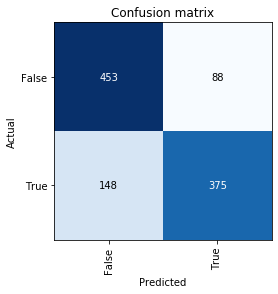

In [19]:
interp.plot_confusion_matrix()

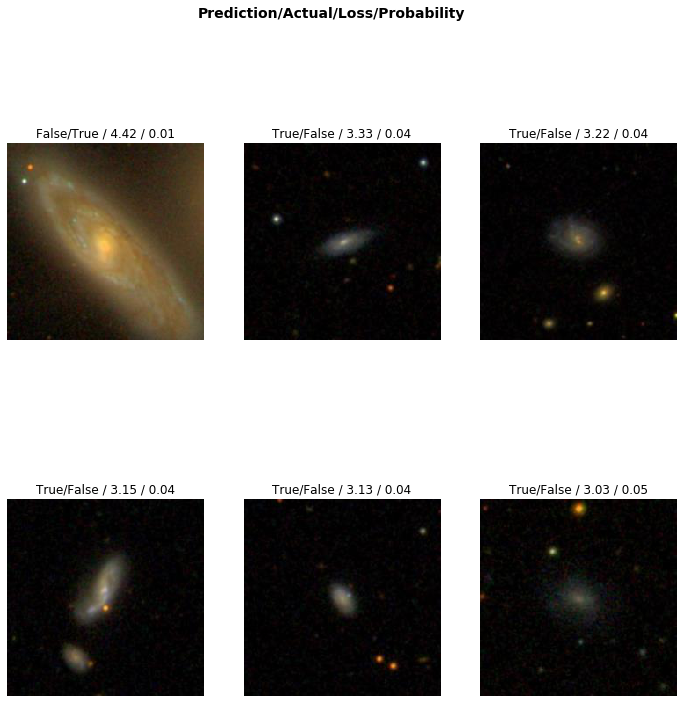

In [20]:
interp.plot_top_losses(6)

Honestly 80% isn't too bad, especially since it may very well be possible to detect the undetected stuff.

## Try super deep pretrained model

In [7]:
learn = cnn_learner(data, models.resnet50, pretrained=True, metrics=[accuracy])

In [24]:
learn.unfreeze()
learn.fit_one_cycle(40, slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.143441,0.852224,0.632519,00:26
1,0.993801,0.802846,0.625000,00:26
2,0.890571,0.674107,0.607143,00:26
3,0.753860,0.641438,0.647556,00:26
4,0.669737,0.607958,0.675752,00:26
5,0.631968,0.642298,0.685150,00:26
6,0.626743,0.670087,0.694549,00:27
7,0.600342,0.534013,0.732143,00:26
8,0.547466,0.787489,0.724624,00:26
9,0.527866,0.491557,0.763158,00:26


In [8]:
# learn.save('classifier-init')
learn.load('classifier-init');

In [9]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

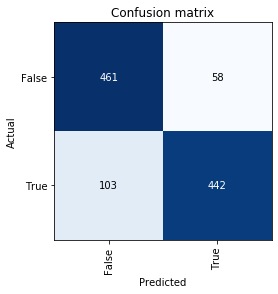

In [10]:
interp.plot_confusion_matrix()

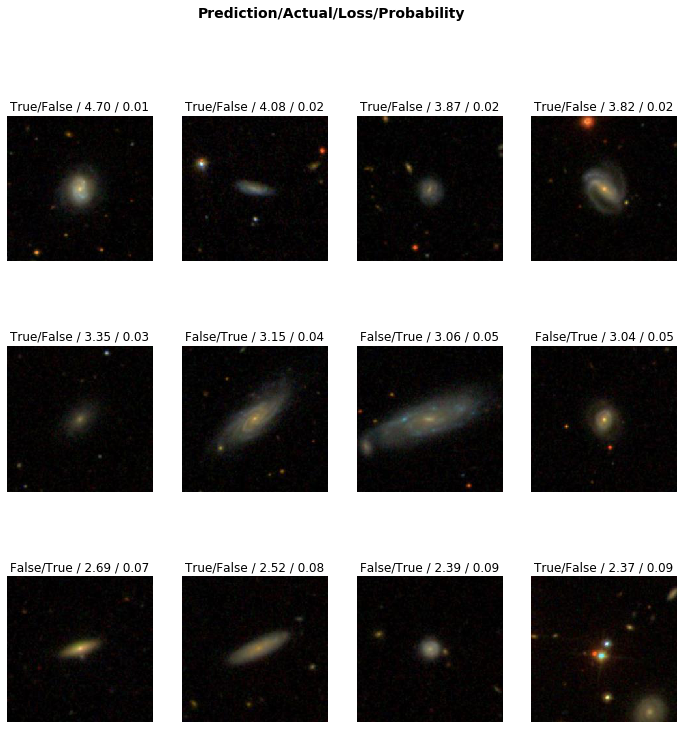

In [12]:
interp.plot_top_losses(12)

In [14]:
val_df = learn.data.valid_ds.inner_df
val_df.sample(3)

,id,ra,dec,z,r,detected
4614,a40_221042,192.34332,9.81778,0.04512,14.89,True
1337,a40_249016,211.76125,14.65555,0.02564,16.10,True
1681,a40_233672,205.62666,12.86028,0.03564,16.48,True


In [18]:
val_df['pred'] = preds.argmax(1)
val_df.sample(10)

,id,ra,dec,z,r,detected,pred
1000,nsa_73965,145.254826,10.945035,0.018518,16.704730,False,0
4222,a40_210454,173.433330,10.088610,0.030710,14.930000,True,1
3089,nsa_52015,148.570133,10.582641,0.039901,16.201624,False,0
722,nsa_51999,148.299734,10.415998,0.040658,15.726115,False,0
2881,a40_244164,214.982500,8.865830,0.044040,15.410000,True,0
1831,a40_248881,211.855000,14.919450,0.025820,15.260000,True,0
3714,nsa_51820,143.405709,9.853506,0.049867,16.677357,False,0
3904,a40_232906,203.457500,4.445000,0.022230,15.850000,True,1
986,nsa_75851,195.997917,14.074684,0.043512,16.832209,False,0
4304,a40_210484,173.901660,15.975000,0.017510,15.560000,True,1


In [20]:
(val_df.detected == val_df.pred).sum() / len(val_df)

0.8486842105263158

**85%**!

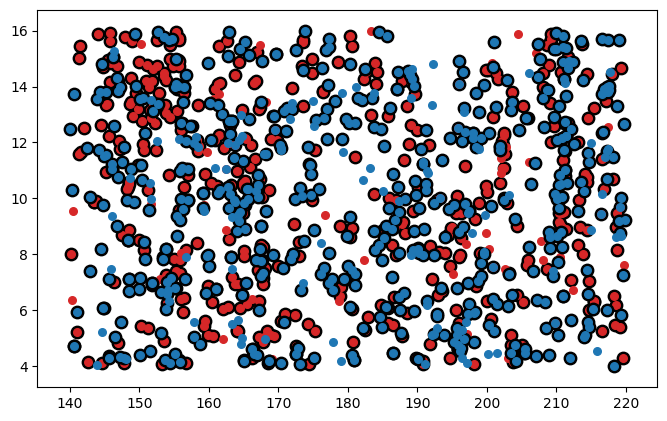

In [43]:
plt.figure(figsize=(8, 5), dpi=100)

plt.scatter(val_df[~val_df.detected & ~val_df.pred].ra, val_df[~val_df.detected & ~val_df.pred].dec, marker='o', s=80, c='k')
plt.scatter(val_df[~val_df.detected].ra, val_df[~val_df.detected].dec, marker='o', c='C3', s=30)

plt.scatter(val_df[val_df.detected & val_df.pred].ra, val_df[val_df.detected & val_df.pred].dec, marker='o', c='k', s=80, facecolor='',)
plt.scatter(val_df[val_df.detected].ra, val_df[val_df.detected].dec, marker='o', c='C0', s=30)